In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
metal = 'K'
embed_dict_path = f"../data/{metal}_train_embeddings.pkl"

In [3]:
from k2 import K2Processor

In [4]:
args = {"datatype":"protein",
        "k":15,
        "quantizer_type":"kmeans",
        "embeddings_path":embed_dict_path,
        "embeddings_type":"dict",
        "mapping_path": None,
        "sample_size":4440,
        "sample_scheme":"random",
        "dataset_path":"/home/data/tinycam/train/train.hdf5",
        "verbosity": "full",
        "so_dict_path": None}
proc = K2Processor(args)

Embeddings path provided, loading embeddings...


In [5]:
proc.fit_quantizer()

Chosen KMeans model for quantization...
sampled 702 known salient objects!
total embeds: 167098
collapsing from dim 512 --> 2


/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/collapse3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


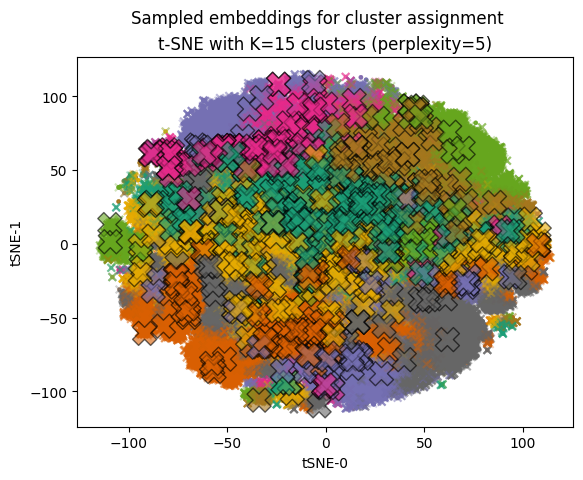

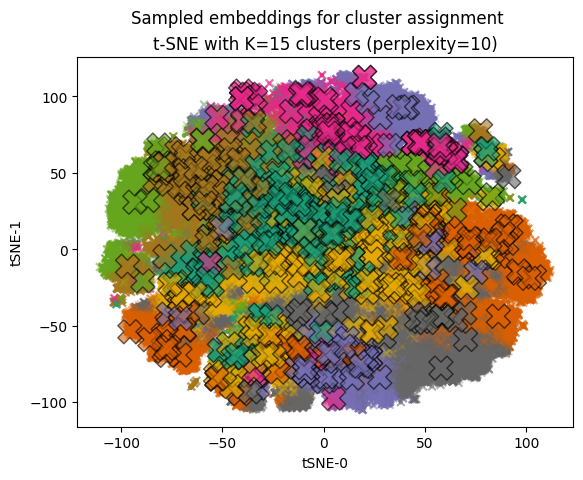

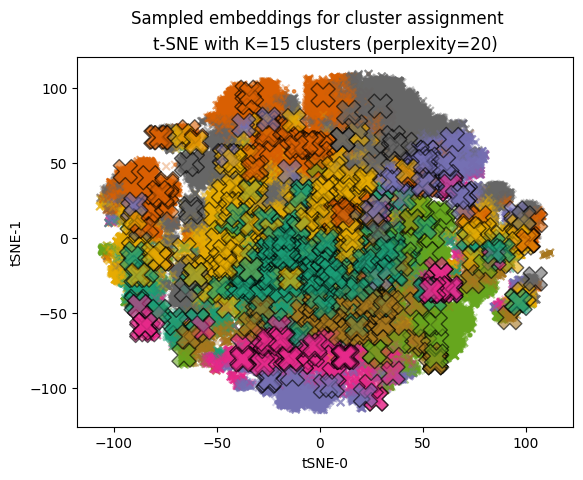

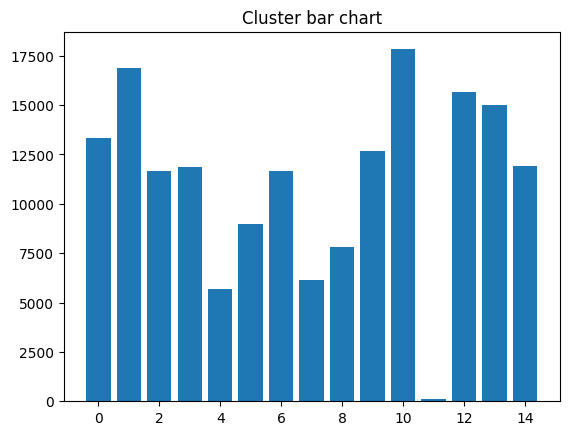

In [10]:
proc.visualize_quantizer()

# Sprite construction

In [6]:
metal = 'K'
G_dir = f"../data/{metal}_train_graphs"

In [3]:
import nglview

In [7]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx

Graph with 552 nodes and 2792 edges


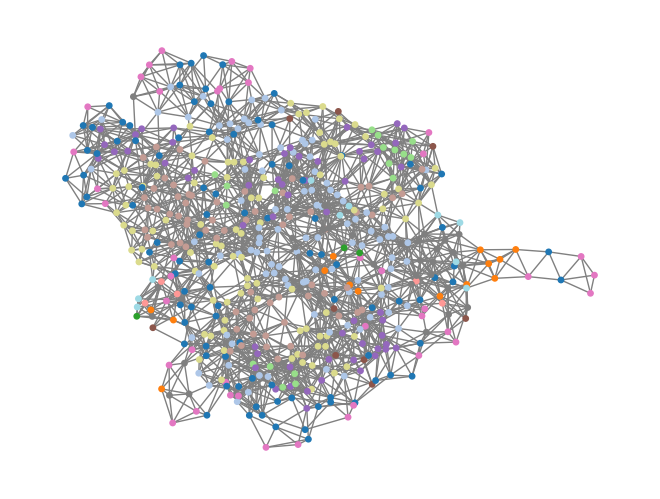

In [11]:
G_id = "1aozB"
G_path = G_dir + "/" + G_id + ".pkl"
G = utils.deserialize(G_path)

sprite = utils.construct_sprite(G, proc)
print(sprite)
utils.visualize_sprite(sprite, modality="graph")

In [11]:
# nglview.show_file(f'/scratch/users/aderry/pdb/{G_id[1:3]}/{G_id}.ent.gz', ext='.ent.gz', compressed=True)
view = nglview.show_pdbid(G_id[:4])
view

NGLWidget()

In [12]:
nx.get_node_attributes(sprite, 'emb').values()

dict_values([0, 6, 6, 6, 4, 4, 6, 4, 4, 6, 12, 12, 12, 12, 12, 1, 1, 1, 1, 0, 12, 12, 12, 12, 12, 12, 12, 6, 7, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 1, 1, 6, 8, 8, 4, 4, 4, 4, 4, 6, 6, 6, 9, 9, 0, 12, 12, 12, 8, 1, 8, 1, 1, 1, 0, 1, 9, 9, 1, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 12, 12, 0, 1, 7, 0, 12, 12, 8, 8, 8, 8, 12, 6, 0, 1, 1, 12, 8, 8, 8, 8, 1, 1, 1, 1, 10, 10, 1, 1, 10, 1, 1, 12, 1, 8, 6, 8, 4, 6, 6, 0, 0, 1, 7, 0, 0, 0, 0, 12, 0, 12, 12, 6, 6, 6, 4, 4, 6, 8, 12, 12, 12, 1, 1, 0, 14, 10, 14, 14, 10, 3, 3, 2, 10, 2, 2, 9, 0, 0, 0, 0, 10, 0, 0, 1, 1, 12, 12, 12, 12, 6, 1, 1, 1, 1, 1, 9, 1, 0, 1, 1, 1, 9, 10, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 1, 1, 0, 0, 12, 6, 6, 6, 6, 6, 1, 9, 12, 12, 8, 8, 8, 8, 4, 8, 6, 6, 1, 1, 1, 12, 12, 8, 8, 8, 8, 8, 12, 9, 12, 12, 8, 8, 8, 8, 12, 1, 1, 1, 1, 12, 12, 0, 12, 12, 12, 12, 12, 12, 8, 12, 8, 12, 1, 1, 12, 12, 8, 8, 8, 8, 8, 12, 12, 0, 0, 0, 0, 9, 0, 6, 12, 12, 8, 8, 8, 8, 12, 1, 1, 0, 0, 0, 0, 0, 0, 12, 8, 12, 8, 8, 8, 6, 6, 6, 1, 1, 0, 0, 9, 0

In [12]:
from k2 import K2Model

In [128]:
# # hyperparameter sweep
# Ks = [10,15,20,25,30]
# rs = [0,1,2,4,8]
# alphas = [0.01, 0.025, 0.05, 1e10]
# taus = [0,1,2]

In [14]:
# label_dict = utils.deserialize("/home/data/tinycam/train/" + modelstr + "-label_dict.pkl")
hparams = {"alpha": 0.01, "tau": 1, "lambda": 0.5}
args = {"modality":"graph",
        "processor":proc,
        "r":2,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir}

In [15]:
k2m = K2Model(args)

In [16]:
k2m.create_train_array()

Creating K2 training array...:   0%|          | 0/454 [00:00<?, ?it/s]

Complete! Created a training array for few-shot classification...
Number of training examples: 454
Number of Kk features: 135


In [20]:
k2m.fit_kernel()

Normalizing training data with TF-IDF...
Differential Expression with alpha,tau: 0.01,1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1

ValueError: `x` and `y` must be of nonzero size.

<BarContainer object of 135 artists>

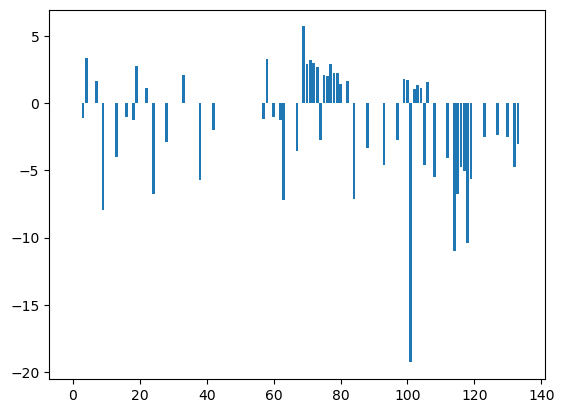

In [135]:
plt.bar(x=range(len(k2m.B)), height=list(k2m.B))

In [136]:
G_file = "/home/data/tinycam/test/Gs_" + modelstr + "/G-test_001"
G = utils.deserialize(G_file)
P = k2m.prospect(G)
print(P)

Graph with 1380 nodes and 5134 edges


Displaying motif graph with log10 scaling


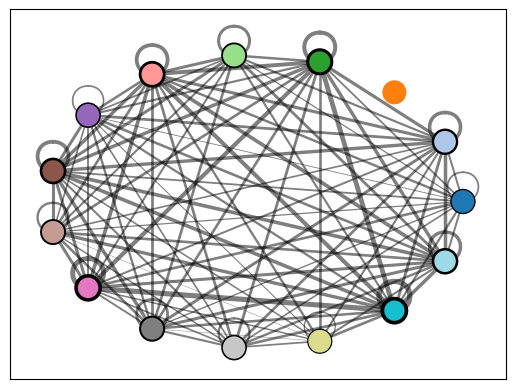

In [137]:
k2m.visualize_motif_graph(G)

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


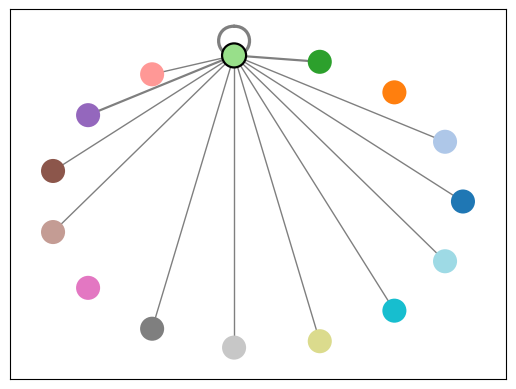

In [138]:
k2m.visualize_motif_graph()

-311.44445224969337 108.37879594798613


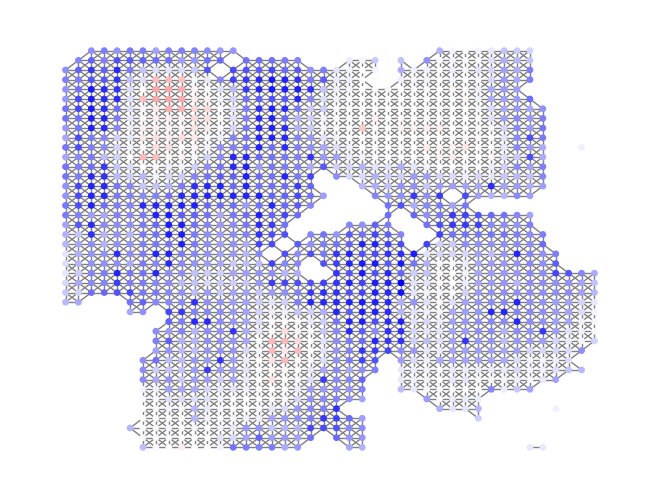

In [157]:
k2m.visualize_prospect_graph(P)

-311.44445224969337 108.37879594798613
311.44445224969337


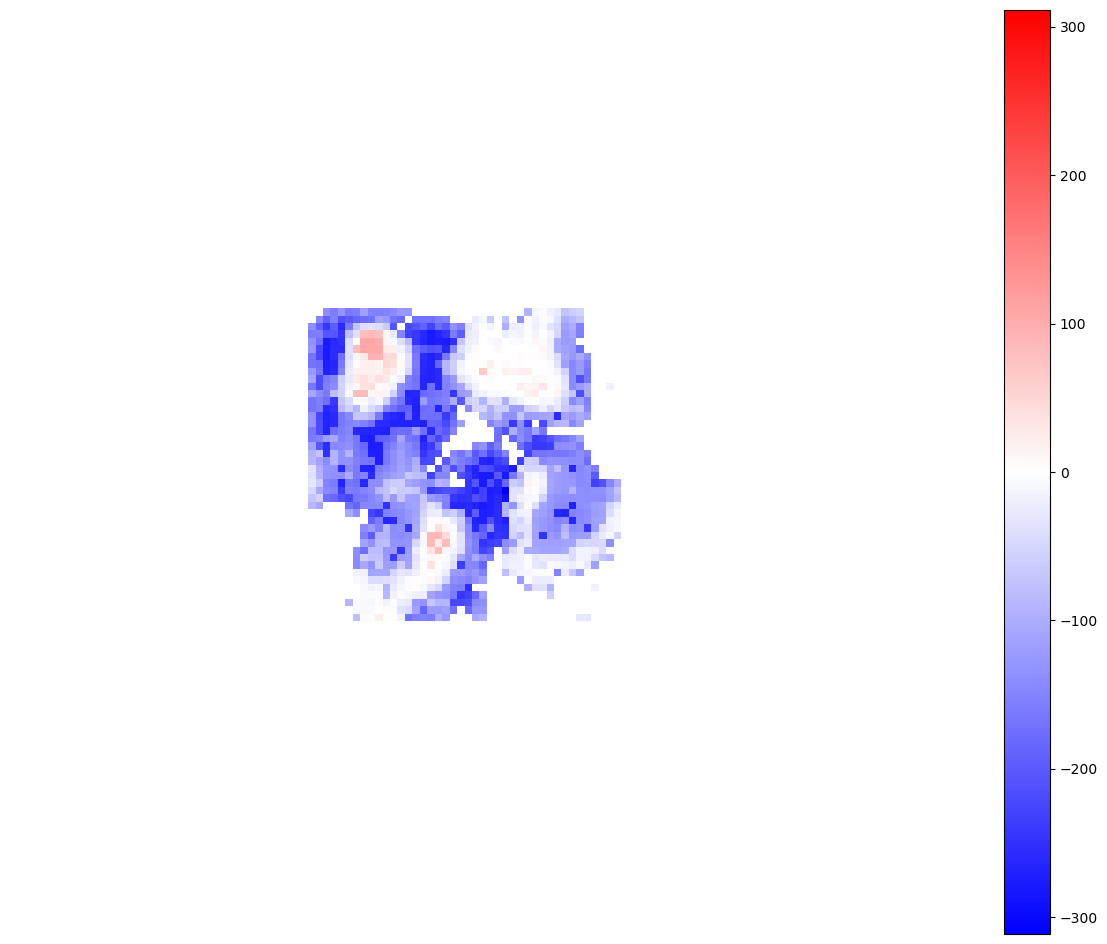

In [154]:
k2m.visualize_prospect_map(P)